Bulk objects inspection; apply GAIA->LS filter transformation

In [1]:
from __future__ import division, print_function
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack, hstack
import fitsio
import sys, os, glob, time, warnings, gc

In [2]:
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'large',
         'axes.titlesize':'large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large',
         'figure.facecolor':'w'} 
plt.rcParams.update(params)

In [3]:
def plot_cutout(img, pixscale, vmin=-1, vmax=1, unit='arcsec'):
    if unit=='arcsec':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])
    elif unit=='arcmin':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/60.
    elif unit=='deg':
        extent = 0.5*pixscale*img.shape[0]*np.array([-1, 1, -1, 1])/3600.
    else:
        raise ValueError('unrecognized unit')
    fig, ax = plt.subplots(figsize=(8, 8))
    dens = ax.imshow(img, aspect='equal', 
               cmap='seismic', extent=extent, vmin=vmin, vmax=vmax)
    ax.axvline(0, ls='--', lw=0.5, color='grey')
    ax.axhline(0, ls='--', lw=0.5, color='grey')
    fig.colorbar(dens, fraction=0.046, pad=0.04)
    # plt.grid(alpha=0.5, lw=0.5)
    return ax

def binned_stats(x, y, bins):
    from scipy import stats
    nmad = lambda x: 1.4826*np.median(np.abs(x-np.median(x)))
    bin_median, bin_edges, binnumber = stats.binned_statistic(x, y, statistic='median', bins=bins)
    bin_spread, _, _ = stats.binned_statistic(x, y, statistic=nmad, bins=bins)    
    bin_center = (bin_edges[1:] + bin_edges[:-1])/2
    return bin_center, bin_edges, bin_median, bin_spread

-------

In [4]:
# gaia1 and gaia2: DECaLS/DES SGC; gaia3: BASS/MzLS; gaia4: DECaLS NGC
gaia_fn = 'gaia4.fits.gz'
gaia = Table.read('/Users/rongpu/Documents/Data/desi_misc/gaia_from_arjun/'+gaia_fn)
print(len(gaia))

if (gaia_fn=='gaia1.fits.gz') or (gaia_fn=='gaia2.fits.gz'):
    mask = gaia['dec']<31.
    gaia = gaia[mask]
    print(len(gaia))
                                  
if (gaia_fn=='gaia3.fits.gz'):
    mask = gaia['dec']>32.375
    gaia = gaia[mask]
    print(len(gaia))

603673


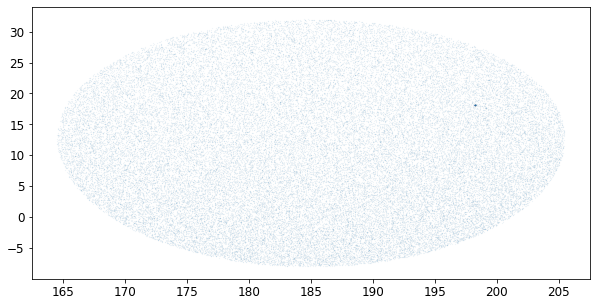

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(gaia['ra'][::10], gaia['dec'][::10], '.', ms=0.1, alpha=0.5)
plt.show()

In [6]:
# Remove duplicates
if len(np.unique(gaia['source_id']))<len(gaia):
    print('Duplicates exist!')
    gaia.sort('source_id')
    mask = gaia['source_id'][1:]==gaia['source_id'][:-1]
    mask = np.concatenate([[False], mask])
    gaia = gaia[~mask]
    
# Remove objects with invalide mask = np.isfinite(gaia['bp_rp'])
mask = np.isfinite(gaia['bp_rp'])
if np.sum(~mask)>0:
    print('{} objects with invalid bp_rp'.format(np.sum(~mask)))
    gaia = gaia[mask]

13074 objects with invalid bp_rp


In [7]:
gaia[:3]

source_id,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,astrometric_excess_noise,phot_g_mean_mag,bp_rp,radial_velocity,radial_velocity_error,phot_variable_flag,teff_val,a_g_val
,deg,mas,deg,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,mas,mag,mag,km / s,km / s,,K,mag
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float64,float64,bytes13,float32,float32
3972839289897271040,175.33439662974035,0.05191210944494655,16.448326687831226,0.03634290128494513,12.030033399069344,0.05149245447649511,-274.36118069089287,0.10621560395004459,-51.21439293774964,0.0643701011354351,0.1254669738812336,12.913276,2.4128094,49.05526871761382,7.633431178230264,NOT_AVAILABLE,3987.0999,nan
3972709719323995008,174.37060429554896,0.04183941064989952,16.545045804969167,0.03199713894303625,0.5669705322675835,0.052760614008978794,-9.39729294774048,0.07467773401770159,0.9378183868299208,0.05871267548761239,0.0,15.140601,0.7431507,nan,nan,NOT_AVAILABLE,6066.1196,0.3125
3972593720847082368,173.61702739987095,0.07503737420602331,16.195790209939982,0.07753651351765961,2.062479963443257,0.11376753310309651,-26.547890305809645,0.13545892864898715,-15.641838566056107,0.14518150887341377,0.0,16.357782,2.0100307,nan,nan,NOT_AVAILABLE,4197.0,1.524


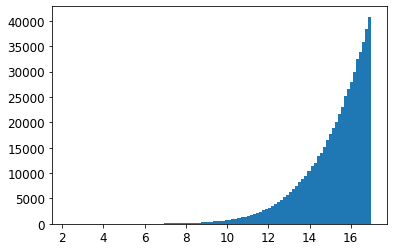

In [8]:
plt.hist(gaia['phot_g_mean_mag'], 100);

In [9]:
# Apply GAIA-LS transformation
from scipy.interpolate import interp1d
transform_interp = {}
for band in ['g', 'r', 'z']:
    tmp = np.load('data/gaia_decals_{}_transform.npz'.format(band))
    bin_center, bin_median, bin_spread = tmp['arr_0'], tmp['arr_1'], tmp['arr_2']
    transform_interp[band] = interp1d(bin_center, bin_median, bounds_error=False, fill_value='extrapolate', kind='linear')
    gaia['decals_'+band] = gaia['phot_g_mean_mag'] + transform_interp[band](gaia['bp_rp'])

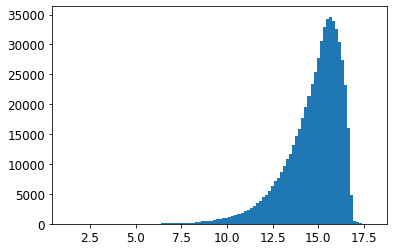

In [10]:
plt.hist(gaia['decals_z'], 100);

In [11]:
# mask = (gaia['phot_g_mean_mag']>16) & ((gaia['phot_g_mean_mag']<18))
# plt.figure(figsize=(8, 8))
# plt.plot((gaia['bp_rp'])[mask], (gaia['decals_g']-gaia['phot_g_mean_mag'])[mask], '.', ms=0.3)
# plt.xlabel('GAIA_BP - GAIA_RP')
# plt.ylabel('DECaLS_G - GAIA_G')
# plt.axis([-0.5, 3.5, -0.5, 3.])
# plt.grid(alpha=0.5)
# plt.show()

------
## Narrow bin of DECaLS g-band magnitude

In [16]:
decals_z_min_list = [10.5, 13.0, 15.5]
decals_z_max_list = [10.51, 13.01, 15.51]

In [17]:
radius_in_bin = []
flux_in_bin = []

for mag_index in range(len(decals_z_min_list)):
        
    decals_z_min, decals_z_max = decals_z_min_list[mag_index], decals_z_max_list[mag_index]
    print('\n', decals_z_min, decals_z_max)
    
    plot_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/plots/04/'    
    band = 'z'
    # img_type = '-resid'
    img_type = ''
    pixscale_str = '0.262'
    pixscale = float(pixscale_str)

    nsamp = 50

    idx = np.where((gaia['decals_z']>decals_z_min) & (gaia['decals_z']<decals_z_max))[0]
    print(len(idx))
    if len(idx)>nsamp:
        np.random.seed(1)
        idx = np.random.choice(idx, size=nsamp, replace=False)
        # print(len(idx))

    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
        
    radius_arr = []
    flux_arr = []

    for index in idx:

        print('phot_g_mean_mag = ', gaia['phot_g_mean_mag'][index])

        ra, dec = gaia['ra'][index], gaia['dec'][index]

        download_dir = '/Users/rongpu/Downloads/gaia_star_cutouts/512/'
        file_path = os.path.join(download_dir, gaia_fn[:-8], 'gaia_{}_{}{}_{}.fits'.format(index, band, img_type, pixscale_str))
        if not os.path.exists(os.path.dirname(file_path)):
            os.makedirs(os.path.dirname(file_path))

        if not os.path.isfile(file_path):
            url = 'http://legacysurvey.org/viewer/cutout.fits?ra={:f}&dec={:f}&layer=dr8{}&pixscale={}&bands={}&size=512'.format(ra, dec, img_type, pixscale_str, band)
            cmd = 'wget -O '+file_path+' \"'+url+'\"'
            print(cmd)
            os.system(cmd)

        img_raw = fitsio.read(file_path)
        img = img_raw / (pixscale**2)

        grid = pixscale * np.linspace(-0.5*(img.shape[0]-1), 0.5*(img.shape[0]-1), img.shape[0])
        xx, yy = np.meshgrid(grid, grid)
        radius = np.sqrt(xx**2 + yy**2).flatten()

        # Remove masked pixels
        mask = img.flatten()!=0
        radius = radius[mask]
        flux = img.flatten()[mask]

        bin_center, _, bin_median, bin_spread = binned_stats(radius, flux, bins=np.linspace(0., 250, 251))
        radius_arr.append(bin_center)
        flux_arr.append(bin_median)

        # vrange = 0.5
        # ax = plot_cutout(img, pixscale, vmin=-vrange, vmax=vrange)
        # ax.set_title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_image.png'))
        # plt.close()

        # plt.figure(figsize=(8, 6))
        # plt.plot(radius, flux, '.', ms=0.5)
        # plt.plot(bin_center, bin_median, c='C1')
        # plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
        # plt.axis([0, 20, -1, 5])
        # plt.axhline(0, lw=1, color='r')
        # plt.grid(alpha=0.5)
        # plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile.png'))
        # plt.close()

        # plt.figure(figsize=(8, 6))
        # plt.loglog(radius, flux, '.', ms=0.5)
        # plt.plot(bin_center, bin_median, c='C1')
        # plt.errorbar(bin_center, bin_median, yerr=bin_spread, lw=1, alpha=0.6, c='C1')
        # plt.axis([.5, 30, .02, 200])
        # plt.grid(alpha=0.5)
        # plt.title('['+band+'-band]  GAIA_G={:.4f}'.format(gaia['phot_g_mean_mag'][index]))
        # plt.savefig(os.path.join(plot_dir, os.path.basename(file_path)[:-5]+'_profile_log.png'))
        # plt.close()

    radius_arr = np.array(radius_arr)
    flux_arr = np.array(flux_arr)
    
    x, _, y, _ = binned_stats(radius_arr.flatten(), flux_arr.flatten(), bins=np.linspace(0., 250, 251))
    radius_in_bin.append(x)
    flux_in_bin.append(y)


 10.5 10.51
91
phot_g_mean_mag =  11.038777
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_351170_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=192.476014&dec=25.066370&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.066004
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_558206_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=170.560146&dec=6.906439&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.739055
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_287655_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=199.782968&dec=10.956717&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.011097
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_339194_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=173.323051&dec=13.707902&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.346687
wget -O /Users/rongpu/Downloads/gaia_sta

phot_g_mean_mag =  11.118671
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_293199_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=178.005501&dec=13.814595&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  11.04211
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_351635_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=192.867848&dec=25.091529&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.633394
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_119204_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=190.318396&dec=8.935252&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.541372
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_469574_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=196.154288&dec=15.021438&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  10.705865
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gai

/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)



 13.0 13.01
546
phot_g_mean_mag =  13.148503
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_213681_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=166.840894&dec=16.217502&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.219295
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_78371_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=192.027420&dec=7.286567&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  14.721446
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_271846_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=197.170890&dec=9.115634&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.283863
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_485381_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=195.974301&dec=-3.039588&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.384868
wget -O /Users/rongpu/Downloads/gaia_star

phot_g_mean_mag =  13.383624
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_292571_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=177.644253&dec=14.107060&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.158525
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_130177_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=171.829697&dec=2.170096&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.380021
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_194890_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=205.072794&dec=11.910536&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.481547
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_239909_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=198.311575&dec=15.590451&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  13.155675
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/ga

/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)



 15.5 15.51
2155
phot_g_mean_mag =  15.593264
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_120678_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=201.039832&dec=3.449381&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  16.900429
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_341276_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=193.678316&dec=-1.433711&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  16.21373
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_530839_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=169.487388&dec=3.960533&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  16.328815
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_75845_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=192.413464&dec=6.458564&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  15.687936
wget -O /Users/rongpu/Downloads/gaia_star_

phot_g_mean_mag =  15.911634
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_176310_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=201.637736&dec=8.259054&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  16.238415
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_544004_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=178.036123&dec=8.128301&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  16.48902
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_38484_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=190.522724&dec=20.594198&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  15.698805
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4/gaia_140258_z_0.262.fits "http://legacysurvey.org/viewer/cutout.fits?ra=191.860987&dec=15.468904&layer=dr8&pixscale=0.262&bands=z&size=512"
phot_g_mean_mag =  15.785073
wget -O /Users/rongpu/Downloads/gaia_star_cutouts/512/gaia4

/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/Users/rongpu/miniconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3405: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


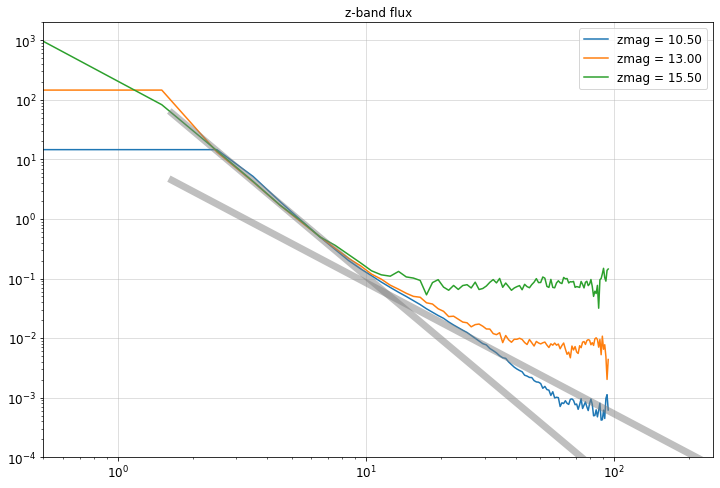

In [42]:
plt.figure(figsize=(12, 8))
for index in range(len(flux_in_bin)):
    # normalize the flux to 13th magnitude stars
    norm = 10**((decals_z_min_list[index]-13)/2.5)
    plt.loglog(radius_in_bin[index], flux_in_bin[index]*norm, lw=1.5, alpha=1., 
               label='{}mag = {:.2f}'.format(band, decals_z_min_list[index]))

x = radius_in_bin[0].copy()
y1 = 1.711 - 3.5*(x-1.179)
y2 = .0 - 2.2*(x-1.179)
plt.loglog(np.exp(x), np.exp(y1), lw=7, alpha=0.5, color='grey')
plt.loglog(np.exp(x), np.exp(y2), lw=7, alpha=0.5, color='grey')
# plt.loglog(np.exp(x), (np.exp(y1)+np.exp(y2)), lw=7, alpha=0.5, color='red')
plt.title('{}-band flux'.format(band))

plt.axis([.5, 250, .0001, 2000])
plt.grid(alpha=0.5)
plt.legend()
plt.show()

In [19]:
t = Table()
t['radius'] = radius_in_bin[0]
for index in range(len(flux_in_bin)):
    t['flux_{}_{:.2f}'.format(band, decals_z_min_list[index])] = flux_in_bin[index]
mask = t['radius']>=95.5
t = t[~mask]

t.write('data/DECaLS_NGC_profiles_z.txt', format='ascii.commented_header')

In [34]:
t

radius,flux_z_10.50,flux_z_13.00,flux_z_15.50
float64,float64,float64,float64
0.5,145.67913818359375,145.67914581298828,95.68818664550781
1.5,145.67916107177734,145.67870330810547,8.269997119903564
2.5,145.6788787841797,13.320349216461182,1.4025798439979553
3.5,51.70279121398926,4.182251930236816,0.4271191358566284
4.5,19.478676795959473,1.6909836530685425,0.17003008723258972
5.5,9.212878704071045,0.8690186440944672,0.0908348597586155
6.5,4.999073505401611,0.5049415826797485,0.050137173384428024
7.5,3.0618584156036377,0.3201626390218735,0.03597890958189964
8.5,1.9976739883422852,0.21794937551021576,0.025158296339213848
